# An√°lisis Exploratorio de las Etiquetas

### Importar librer√≠as



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib

In [3]:
plt.style.use("seaborn-v0_8-darkgrid")

### Limpiar el data set
(Eliminar registros que no son del pecho)

In [4]:
df1 = pd.read_csv("../datos/labels/train_predicted_labels.csv")   

with open("../datos/labels/no_chest_train.txt", "r") as f:
    rutas_largas = f.read().splitlines()
nombres_largos = [ruta.split("/")[-1] for ruta in rutas_largas]
df = df1[~df1.iloc[:,0].isin(nombres_largos)].copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46397 entries, 0 to 47148
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   VolumeName                          46397 non-null  object
 1   Medical material                    46397 non-null  int64 
 2   Arterial wall calcification         46397 non-null  int64 
 3   Cardiomegaly                        46397 non-null  int64 
 4   Pericardial effusion                46397 non-null  int64 
 5   Coronary artery wall calcification  46397 non-null  int64 
 6   Hiatal hernia                       46397 non-null  int64 
 7   Lymphadenopathy                     46397 non-null  int64 
 8   Emphysema                           46397 non-null  int64 
 9   Atelectasis                         46397 non-null  int64 
 10  Lung nodule                         46397 non-null  int64 
 11  Lung opacity                        46397 non-null  int64 


In [6]:
df.head()

VolumeName  Medical material  Arterial wall calcification  \
0  train_1_a_1.nii.gz                 0                            1   
1  train_1_a_2.nii.gz                 0                            1   
2  train_2_a_1.nii.gz                 0                            1   
3  train_2_a_2.nii.gz                 0                            1   
4  train_3_a_1.nii.gz                 0                            1   

   Cardiomegaly  Pericardial effusion  Coronary artery wall calcification  \
0             0                     0                                   0   
1             0                     0                                   0   
2             0                     0                                   0   
3             0                     0                                   0   
4             1                     0                                   1   

   Hiatal hernia  Lymphadenopathy  Emphysema  Atelectasis  Lung nodule  \
0              0                0          0            1            0   
1              0                0          0            1            0   
2              0                0          1            1            1   
3              0                0          1            1            1   
4              0                1          0            0            1   

   Lung opacity  Pulmonary fibrotic sequela  Pleural effusion  \
0             1                           0                 0   
1             1                           0                 0   
2             0                           0                 0   
3             0                           0                 0   
4             1                           1                 0   

   Mosaic attenuation pattern  Peribronchial thickening  Consolidation  \
0                           0                         1              1   
1                           0                         1              1   
2                           0                         1              0   
3                           0                         1              0   
4                           0                         1              0   

   Bronchiectasis  Interlobular septal thickening  
0               0                               0  
1               0                               0  
2               0                               0  
3               0                               0  
4               1                               0

In [7]:
disease_cols = df.columns[2:] #1 si medical material es enfermedad y 2 si no
disease_counts = df[disease_cols].sum().sort_values(ascending=False)
disease_counts


Lung nodule                           21096
Lung opacity                          17147
Arterial wall calcification           13016
Pulmonary fibrotic sequela            12411
Atelectasis                           11968
Lymphadenopathy                       11939
Coronary artery wall calcification    11663
Emphysema                              8996
Consolidation                          8223
Hiatal hernia                          6618
Pleural effusion                       5593
Cardiomegaly                           5025
Peribronchial thickening               4911
Bronchiectasis                         4691
Interlobular septal thickening         3688
Mosaic attenuation pattern             3487
Pericardial effusion                   3332
dtype: int64

In [33]:
total_registros = disease_counts.sum()
print(f"Total de registros: {total_registros:,}")

Total de registros: 153,804


# Gr√°ficas

### Barras

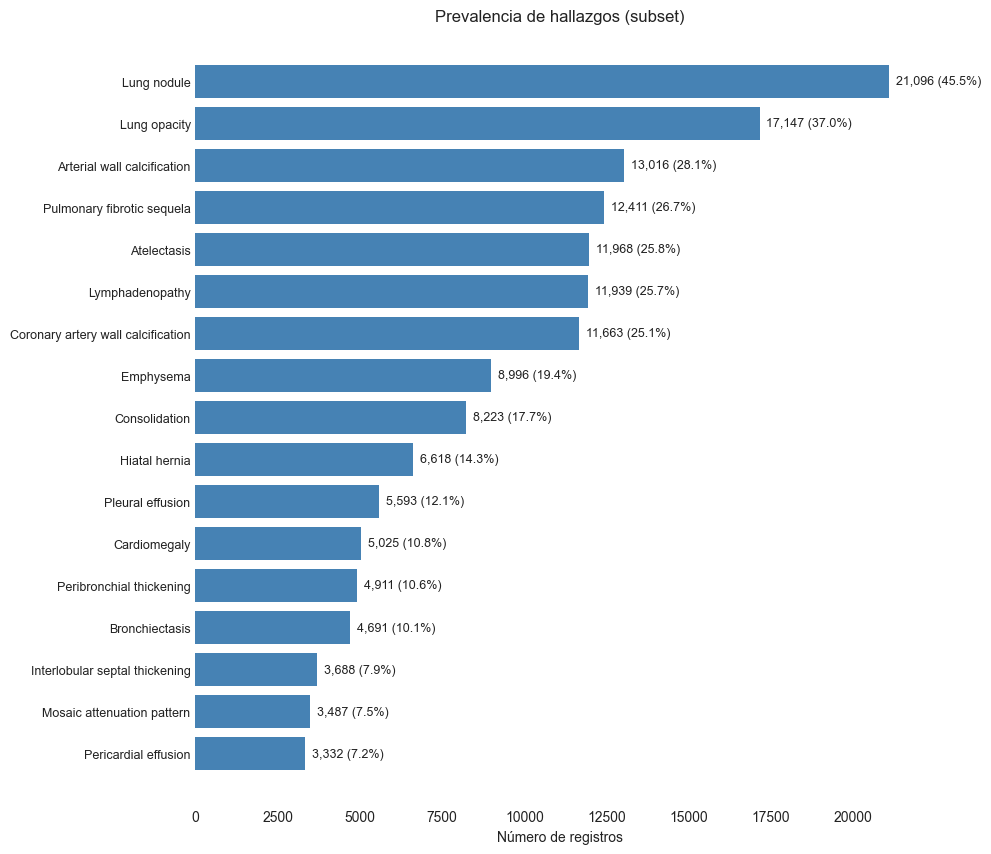

In [40]:
counts = disease_counts.sort_values(ascending=True)
pct = counts / len(df) * 100

plt.figure(figsize=(10, 0.45*len(counts)+1), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

ax.barh(range(len(counts)), counts.values, color="steelblue")

m = counts.max()
for i, (c, p) in enumerate(zip(counts.values, pct.values)):
    ax.text(c + m*0.01, i, f"{c:,} ({p:.1f}%)", va='center', fontsize=9, color="#222")

ax.set_yticks(range(len(counts)))
ax.set_yticklabels(counts.index, fontsize=9)
ax.set_xlabel("N√∫mero de registros")
ax.set_title("Prevalencia de hallazgos (subset)")

for spine in ("top","right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

### Nota
Los porcentajes mostrados son prevalencias independientes (registros con cada hallazgo / total de registros). Como un mismo estudio puede tener varias condiciones (dataset multi‚Äëlabel), las prevalencias se superponen y su suma supera 100%. La suma de todos los conteos es 153,804 sobre 46,397 estudios ‚Üí en promedio cada estudio tiene ‚âà3.31 hallazgos; por eso la suma de las prevalencias es ‚âà3.31 √ó 100% ‚âà 331%. Esto es normal y no indica error.

### Heat map

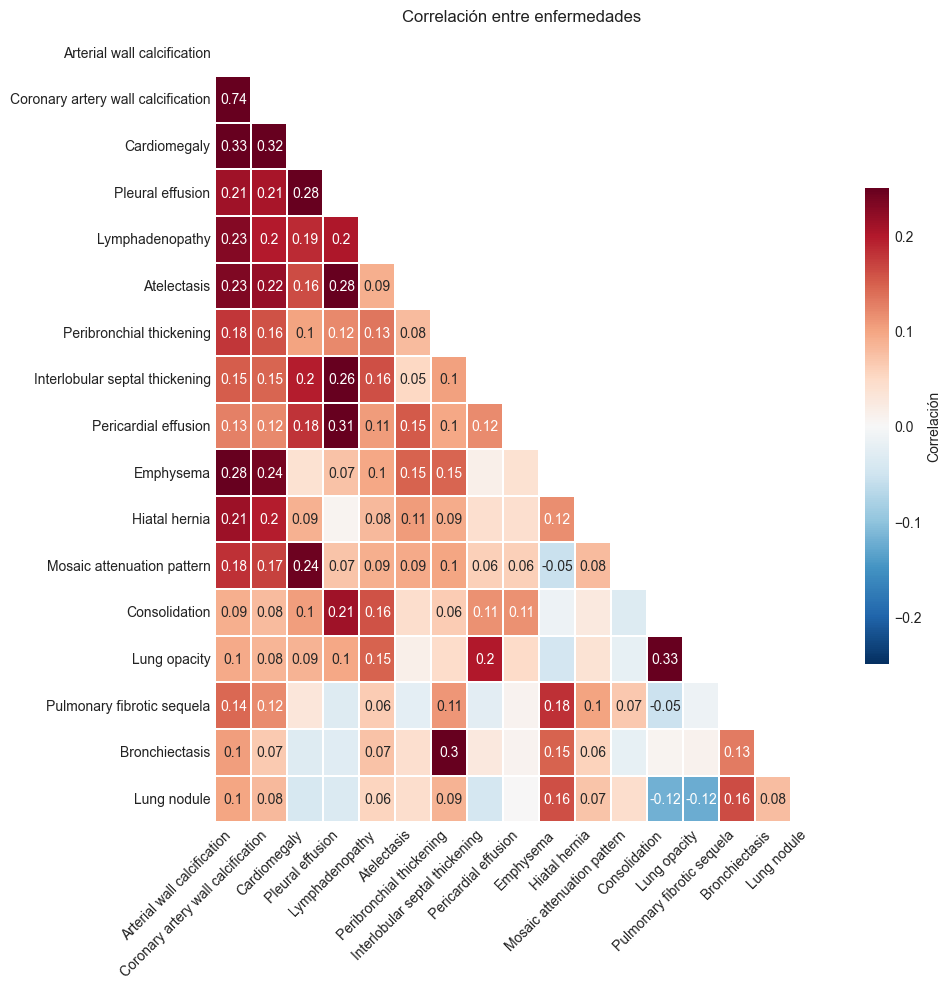

In [44]:
corr = df[disease_cols].corr()
vals, vecs = np.linalg.eigh(corr)
pc1 = vecs[:, vals.argmax()]
order = np.argsort(pc1)
corr_o = corr.iloc[order, order]

mask = np.triu(np.ones_like(corr_o, dtype=bool))

ann = corr_o.round(2).astype(str)
ann[np.abs(corr_o.values) < 0.05] = ""

plt.figure(figsize=(10,10))
sns.heatmap(
    corr_o,
    mask=mask,
    cmap="RdBu_r",
    center=0,
    vmin=-0.25, vmax=0.25,
    linewidths=.3,
    annot=ann,
    fmt="",
    cbar_kws={"shrink":0.6, "label":"Correlaci√≥n"}
)
plt.title("Correlaci√≥n entre enfermedades")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Analisis

Este mapa muestra qu√© tan seguido aparecen juntas dos condiciones en los mismos estudios. Cada cuadradito compara un par:

Rojo: las dos suelen salir juntas m√°s de lo esperado.
Azul: casi no coinciden (aparecen separadas).
Blanco o muy claro: no hay relaci√≥n clara.
La escala va de -0.25 a +0.25 (valores fuera de ese rango se ‚Äúrecortan‚Äù para que los colores se distingan mejor). No significa porcentaje, solo indica fuerza y direcci√≥n de la relaci√≥n. No implica causa; solo refleja coincidencia en este conjunto de datos

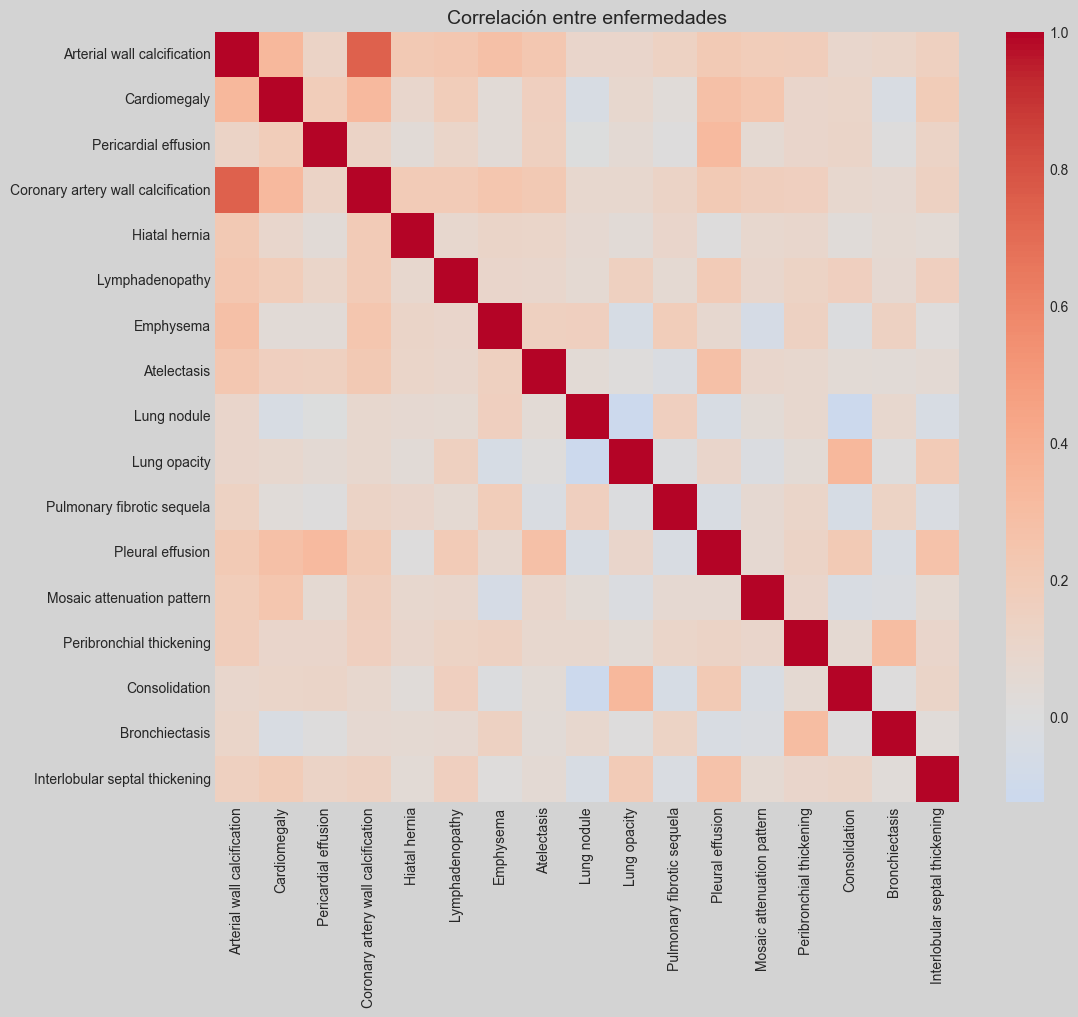

In [10]:
corr = df[disease_cols].corr()

plt.figure(figsize=(12,10), facecolor="lightgray")
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlaci√≥n entre enfermedades", fontsize=14)
plt.show()


# ü´Ä Cardiovasculares 

### Arterial wall calcification

**Qu√© es:** Dep√≥sitos de calcio en la pared de arterias tor√°cicas (ej. aorta).  
**Significado:** Indicador de aterosclerosis / degeneraci√≥n vascular cr√≥nica.  
**En CT:** Focos o l√≠neas hiperdensas adheridas a la pared (visibles sin contraste).  
**Relevancia:** Marcador de riesgo cardiovascular y posible dificultad t√©cnica en procedimientos.  

In [39]:
cond = "Arterial wall calcification"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%)")

Arterial wall calcification: 13,016 registros (28.05%)


####
Insight: Presente en cerca de 1 de cada 3‚Äì4 registros, indicando carga ateroscler√≥tica relevante.  

### Coronary artery wall calcification

Qu√© es: Calcificaci√≥n en las arterias coronarias, marcador de enfermedad ateroscler√≥tica coronaria.

En CT: Lesiones blancas en la trayectoria de las coronarias. Puede cuantificarse con el score de calcio (Agatston).

In [13]:
print(f" presente en {disease_counts["Coronary artery wall calcification"]} registros ({disease_percentages["Coronary artery wall calcification"]:.2f}%)")

 presente en 11663 registros (25.14%)


### Cardiomegaly

Qu√© es: Agrandamiento del coraz√≥n, asociado a insuficiencia card√≠aca, cardiomiopat√≠as o valvulopat√≠as.

En CT: √çndice cardiotor√°cico aumentado; silueta card√≠aca m√°s ancha de lo normal.

In [14]:
print(f" presente en {disease_counts["Cardiomegaly"]} registros ({disease_percentages["Cardiomegaly"]:.2f}%)")

 presente en 5025 registros (10.83%)


### Pericardial effusion


Qu√© es: Acumulaci√≥n de l√≠quido en el espacio peric√°rdico.

En CT: Banda hipodensa (oscura) que rodea al coraz√≥n, delimitada por el pericardio.



In [15]:
print(f" presente en {disease_counts["Pericardial effusion"]} registros ({disease_percentages["Pericardial effusion"]:.2f}%) Patolog√≠a m√°s rara en el data set")

 presente en 3332 registros (7.18%) Patolog√≠a m√°s rara en el data set


# ü´Å Pulmonares


### Emphysema

Qu√© es: Destrucci√≥n de alv√©olos ‚Üí hiperinsuflaci√≥n y √°reas sin intercambio gaseoso.

En CT: √Åreas hipodensas (negras) sin paredes vasculares, con aumento del tama√±o pulmonar.


In [16]:
print(f" presente en {disease_counts["Emphysema"]} registros ({disease_percentages["Emphysema"]:.2f}%)")

 presente en 8996 registros (19.39%)



### Atelectasis

Qu√© es: Colapso parcial o completo del pulm√≥n o de un segmento.

En CT: Disminuci√≥n de volumen, desplazamiento de estructuras y aumento de densidad local.

In [17]:
print(f" presente en {disease_counts["Atelectasis"]} registros ({disease_percentages["Atelectasis"]:.2f}%)")

 presente en 11968 registros (25.79%)



### Lung nodule



Qu√© es: Lesi√≥n redondeada <3 cm dentro del pulm√≥n. Puede ser benigna o maligna.

En CT: Opacidad focal bien delimitada, evaluable en tama√±o, bordes y atenuaci√≥n.

In [18]:
print(f" presente en {disease_counts["Lung nodule"]} registros ({disease_percentages["Lung nodule"]:.2f}%) Patolog√≠a m√°s com√∫n en el data set")

 presente en 21096 registros (45.47%) Patolog√≠a m√°s com√∫n en el data set


### Lung opacity

Qu√© es: Cualquier aumento de densidad en el pulm√≥n (ej. neumon√≠a, edema, hemorragia).

En CT: Zona blanca dentro del par√©nquima, de extensi√≥n variable.

In [19]:
disease_counts["Lung opacity"]
print(f" presente en {disease_counts["Lung opacity"]} registros ({disease_percentages["Lung opacity"]:.2f}%)")

 presente en 17147 registros (36.96%)


### Pulmonary fibrotic sequela

Qu√© es: Cicatrizaci√≥n del pulm√≥n tras inflamaci√≥n o infecci√≥n cr√≥nica.

En CT: Reticulaci√≥n, bronquiectasias por tracci√≥n, distorsi√≥n arquitect√≥nica.

In [20]:
print(f" presente en {disease_counts["Pulmonary fibrotic sequela"]} registros ({disease_percentages["Pulmonary fibrotic sequela"]:.2f}%)")

 presente en 12411 registros (26.75%)




### Mosaic attenuation pattern

Qu√© es: Diferencias en la densidad pulmonar por alteraciones vasculares o de v√≠a a√©rea.

En CT: √Åreas alternadas de mayor y menor atenuaci√≥n en par√©nquima pulmonar.

In [21]:
print(f" presente en {disease_counts["Mosaic attenuation pattern"]} registros ({disease_percentages["Mosaic attenuation pattern"]:.2f}%)")

 presente en 3487 registros (7.52%)


### Peribronchial thickening

Qu√© es: Engrosamiento de las paredes bronquiales, asociado a inflamaci√≥n o infecci√≥n cr√≥nica.

En CT: Anillos bronquiales engrosados (‚Äúdonut sign‚Äù), bronquios m√°s visibles.

In [22]:
print(f" presente en {disease_counts["Peribronchial thickening"]} registros ({disease_percentages["Peribronchial thickening"]:.2f}%)")

 presente en 4911 registros (10.58%)


### Consolidation

Qu√© es: Sustituci√≥n de aire alveolar por l√≠quido, c√©lulas o exudado (ej. neumon√≠a).

En CT: Opacidad homog√©nea que borra los vasos y bronquios.

In [23]:
print(f" presente en {disease_counts["Consolidation"]} registros ({disease_percentages["Consolidation"]:.2f}%)")

 presente en 8223 registros (17.72%)


### Bronchiectasis

Qu√© es: Dilataci√≥n irreversible de los bronquios.

En CT: Bronquios dilatados > di√°metro de arterias adyacentes, con engrosamiento de la pared.

In [24]:
print(f" presente en {disease_counts["Bronchiectasis"]} registros ({disease_percentages["Bronchiectasis"]:.2f}%)")

 presente en 4691 registros (10.11%)


### Interlobular septal thickening

Qu√© es: Engrosamiento de los septos interlobulares por l√≠quido, fibrosis o infiltraci√≥n.

En CT: L√≠neas finas que delimitan lobulillos secundarios, patr√≥n reticular.

In [25]:
print(f" presente en {disease_counts["Interlobular septal thickening"]} registros ({disease_percentages["Interlobular septal thickening"]:.2f}%)")

 presente en 3688 registros (7.95%)



# ü´Åü´Ä Otros hallazgos tor√°cicos

### Pleural effusion

Qu√© es: Acumulaci√≥n de l√≠quido en la cavidad pleural.

En CT: Colecci√≥n hipodensa en el espacio pleural, con menisco caracter√≠stico.

In [26]:
print(f" presente en {disease_counts["Pleural effusion"]} registros ({disease_percentages["Pleural effusion"]:.2f}%)")

 presente en 5593 registros (12.05%)


### Lymphadenopathy

Qu√© es: Agrandamiento patol√≥gico de ganglios linf√°ticos (ej. por infecci√≥n, tumor, inflamaci√≥n).

En CT: N√≥dulos redondeados o lobulados en mediastino, >10 mm eje corto.

In [27]:
print(f" presente en {disease_counts["Lymphadenopathy"]} registros ({disease_percentages["Lymphadenopathy"]:.2f}%)")

 presente en 11939 registros (25.73%)


### Hiatal hernia

Qu√© es: Protrusi√≥n del est√≥mago a trav√©s del diafragma hacia el t√≥rax.

En CT: Masa con densidad de aire/l√≠quido detr√°s del coraz√≥n, en hiato esof√°gico.

In [28]:
print(f" presente en {disease_counts["Hiatal hernia"]} registros ({disease_percentages["Hiatal hernia"]:.2f}%)")

 presente en 6618 registros (14.26%)


# N√∫mero de enfermedades por registro 

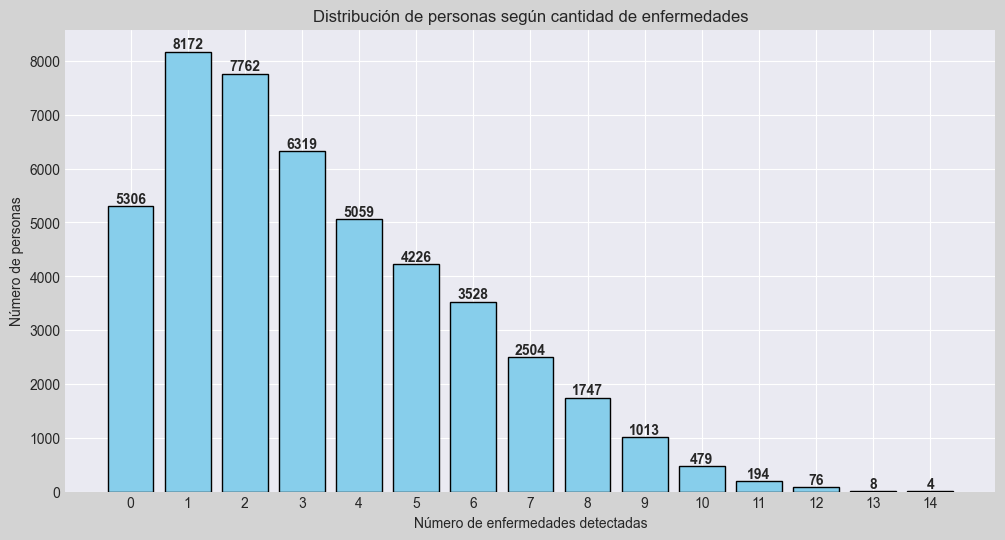

In [29]:
df.loc[:, "n_enfermedades"] = df[disease_cols].sum(axis=1)

rango = range(0, int(df["n_enfermedades"].max()) + 1)
conteo = df["n_enfermedades"].value_counts().reindex(rango, fill_value=0)

plt.figure(figsize=(12,6), facecolor="lightgrey")
bars = plt.bar(conteo.index, conteo.values, color="skyblue", edgecolor="black")

plt.xlabel("N√∫mero de enfermedades detectadas")
plt.ylabel("N√∫mero de personas")
plt.title("Distribuci√≥n de personas seg√∫n cantidad de enfermedades")
plt.xticks(conteo.index)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"{int(height)}",
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.show()

### Notar que no existen registros con mas de 14 patolig√≠as a la vez